<a href="https://colab.research.google.com/github/lucdekeijzer/Assignment_3_Spaceship_Titanic/blob/main/Assignment_3_Spaceship_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
dataset = 'spaceship-titanic'

!kaggle competitions download -c $dataset

zip_file = f"{dataset}.zip"
destination_dir = f"/content/{dataset}"

if not os.path.exists(zip_file):
    print(f"Error: {zip_file} not found.")
else:
    !unzip -q $zip_file -d $destination_dir
    !rm $zip_file

In [3]:
# used for debugging
!pip install -Uqq ipdb
import ipdb
%pdb on
#ipdb.set_trace()

Automatic pdb calling has been turned ON


In [28]:
import pandas as pd
train_data_df = pd.read_csv("/content/spaceship-titanic/train.csv")
test_data_df = pd.read_csv("/content/spaceship-titanic/test.csv")
print(train_data_df)

     PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0001_01     Europa     False     B/0/P    TRAPPIST-1e  39.0  False   
1        0002_01      Earth     False     F/0/S    TRAPPIST-1e  24.0  False   
2        0003_01     Europa     False     A/0/S    TRAPPIST-1e  58.0   True   
3        0003_02     Europa     False     A/0/S    TRAPPIST-1e  33.0  False   
4        0004_01      Earth     False     F/1/S    TRAPPIST-1e  16.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
8688     9276_01     Europa     False    A/98/P    55 Cancri e  41.0   True   
8689     9278_01      Earth      True  G/1499/S  PSO J318.5-22  18.0  False   
8690     9279_01      Earth     False  G/1500/S    TRAPPIST-1e  26.0  False   
8691     9280_01     Europa     False   E/608/S    55 Cancri e  32.0  False   
8692     9280_02     Europa     False   E/608/S    TRAPPIST-1e  44.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa 

In [29]:
train_data_df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [61]:
# print(len(train_data_df))
# train_data_df_filled_na = train_data_df.fillna(method = "ffill")
# print(len(train_data_df))

bool_columns = ['CryoSleep', 'VIP', 'Transported']

for col in bool_columns:
    train_data_df[col] = train_data_df[col].astype(bool)

# categorical_columns = ['HomePlanet', 'Cabin', 'Destination', 'Name']

# for col in categorical_columns:
#     train_data_df[col] = pd.factorize(train_data_df[col])[0]


categorical_features=['PassengerId',"HomePlanet",'Destination','Cabin','Name']
for col in categorical_features:
     train_data_df.loc[:,col].fillna( train_data_df.loc[:,col].mode(), inplace=True)
for col in set(train_data_df.columns)-set(categorical_features):
     train_data_df.loc[:,col].fillna( train_data_df.loc[:,col].mean(), inplace=True)

print(set(train_data_df.columns)-set(categorical_features))
print(train_data_df)

{'VIP', 'FoodCourt', 'Transported', 'RoomService', 'amenities', 'Age', 'CryoSleep', 'No_spending', 'ShoppingMall', 'Spa', 'VRDeck'}
     PassengerId  HomePlanet  CryoSleep  Cabin  Destination   Age    VIP  \
0        0001_01           0      False      0            0  39.0  False   
1        0002_01           1      False      1            0  24.0  False   
2        0003_01           0      False      2            0  58.0   True   
3        0003_02           0      False      2            0  33.0  False   
4        0004_01           1      False      3            0  16.0  False   
...          ...         ...        ...    ...          ...   ...    ...   
8688     9276_01           0      False   6556            2  41.0   True   
8689     9278_01           1       True   6557            1  18.0  False   
8690     9279_01           1      False   6558            0  26.0  False   
8691     9280_01           0      False   6559            2  32.0  False   
8692     9280_02           0    

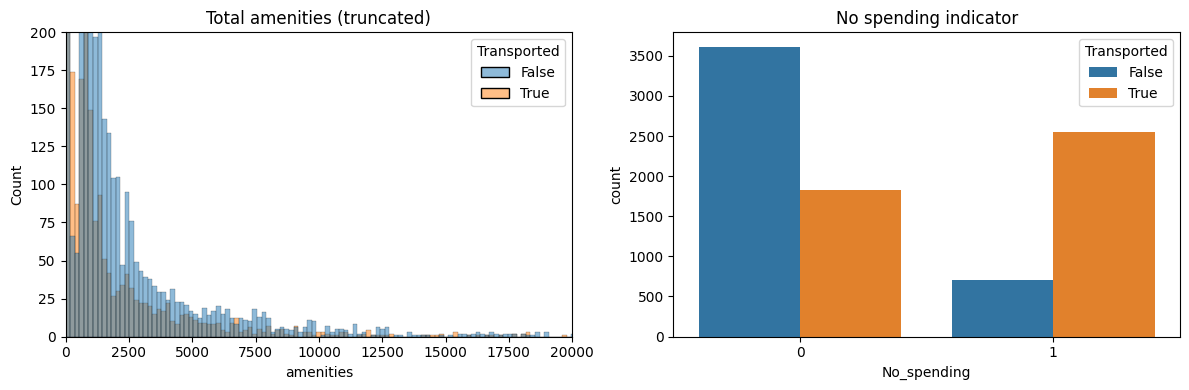

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

#added the features expenditure and no spending which is based on the persons spendings on the ship
train_data_df['amenities']=train_data_df[exp_feats].sum(axis=1)
train_data_df['No_spending']=(train_data_df['amenities']==0).astype(int)

# Plot distribution of new features
fig=plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(data=train_data_df, x='amenities', hue='Transported', bins=200)
plt.title('Total amenities (truncated)')
plt.ylim([0,200])
plt.xlim([0,20000])

plt.subplot(1,2,2)
sns.countplot(data=train_data_df, x='No_spending', hue='Transported')
plt.title('No spending indicator')
fig.tight_layout()

In [32]:
train_data_df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep         0
Cabin           199
Destination     182
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            200
Transported       0
amenities         0
No_spending       0
dtype: int64

In [33]:
print(train_data_df.dtypes)

PassengerId      object
HomePlanet       object
CryoSleep          bool
Cabin            object
Destination      object
Age             float64
VIP                bool
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
amenities       float64
No_spending       int64
dtype: object


     PassengerId  HomePlanet  CryoSleep  Cabin  Destination   Age    VIP  \
0        0001_01           0      False      0            0  39.0  False   
1        0002_01           1      False      1            0  24.0  False   
2        0003_01           0      False      2            0  58.0   True   
3        0003_02           0      False      2            0  33.0  False   
4        0004_01           1      False      3            0  16.0  False   
...          ...         ...        ...    ...          ...   ...    ...   
8688     9276_01           0      False   6556            2  41.0   True   
8689     9278_01           1       True   6557            1  18.0  False   
8690     9279_01           1      False   6558            0  26.0  False   
8691     9280_01           0      False   6559            2  32.0  False   
8692     9280_02           0      False   6559            0  44.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  Name  Transported  \
0     

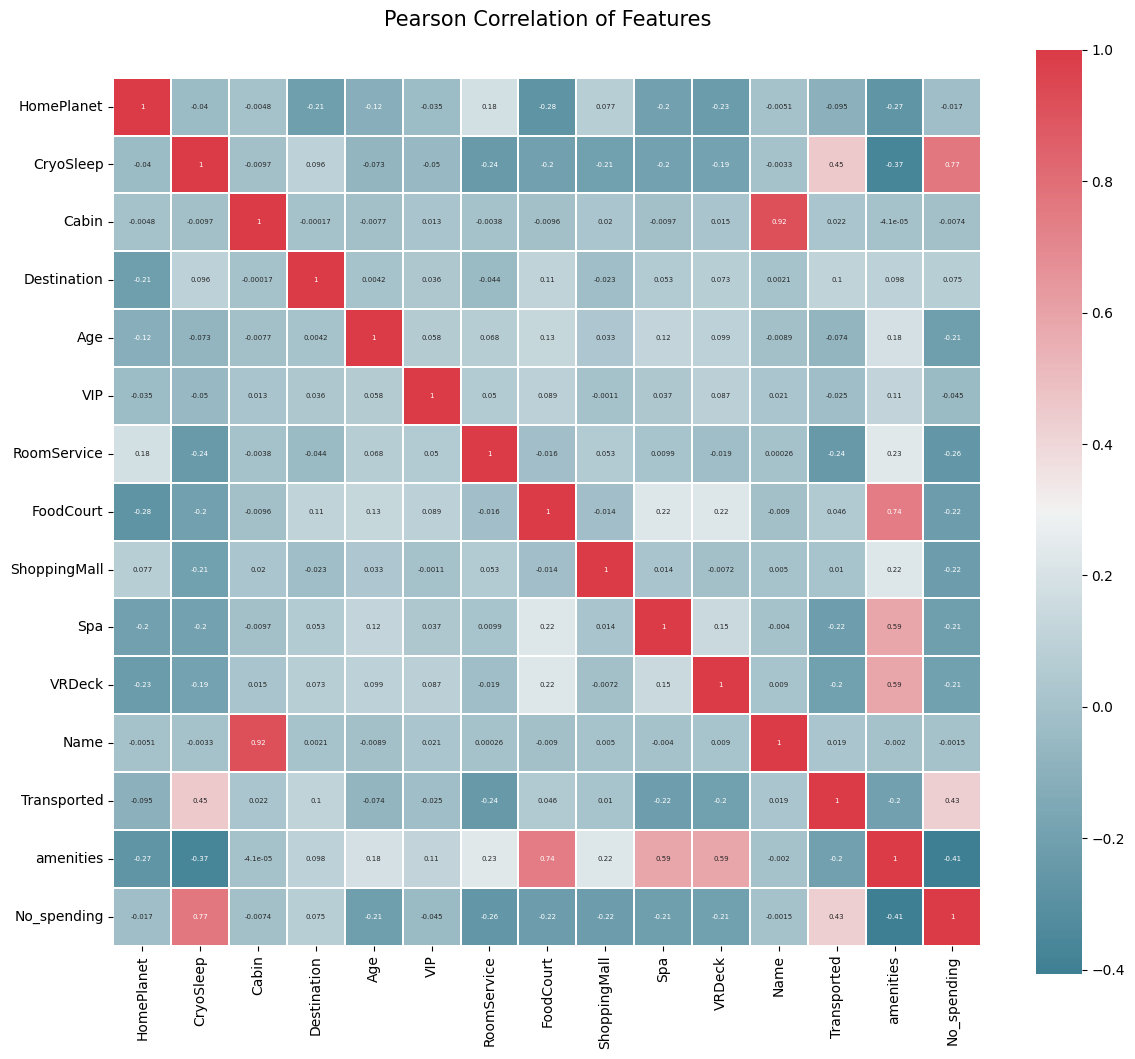

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)

    _ = sns.heatmap(

        df.corr(numeric_only=True),
        cmap = colormap,
        square=True,

        ax=ax,
        annot=True,
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize': 5 }
    )

    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(train_data_df)
print(train_data_df)

In [64]:
len(train_data_df)
X = train_data_df.loc[:, train_data_df.columns != 'Transported']
y = train_data_df['Transported']

In [65]:
# Encoding
from sklearn.preprocessing import LabelEncoder

# Encoding
# from sklearn.preprocessing import OneHotEncoder
# oneHotEncoder = OneHotEncoder(handle_unknown='ignore')
# # encode the entire training dataset
# columns_to_encode = ["PassengerId", "HomePlanet", "Destination", "Cabin", "Name"]
# oneHotEncoder.fit(X[columns_to_encode])
# # encode the specified columns individually
# X[columns_to_encode] = oneHotEncoder.transform(X[columns_to_encode])
label_encoder = LabelEncoder()
for feature in categorical_features:
 X[feature] = label_encoder.fit_transform(X[feature])
print(X)

      PassengerId  HomePlanet  CryoSleep  Cabin  Destination   Age    VIP  \
0               0           1      False      1            1  39.0  False   
1               1           2      False      2            1  24.0  False   
2               2           1      False      3            1  58.0   True   
3               3           1      False      3            1  33.0  False   
4               4           2      False      4            1  16.0  False   
...           ...         ...        ...    ...          ...   ...    ...   
8688         8688           1      False   6557            3  41.0   True   
8689         8689           2       True   6558            2  18.0  False   
8690         8690           2      False   6559            1  26.0  False   
8691         8691           1      False   6560            3  32.0  False   
8692         8692           1      False   6560            1  44.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  Name  amenities

<ipython-input-65-887c2219c3e2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = label_encoder.fit_transform(X[feature])
<ipython-input-65-887c2219c3e2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature] = label_encoder.fit_transform(X[feature])
<ipython-input-65-887c2219c3e2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

In [37]:
for feature in categorical_features:
 print('max value of feature '+feature+' is '+str(X[feature].max()))

max value of feature PassengerId is 8692
max value of feature HomePlanet is 3
max value of feature Destination is 3
max value of feature Cabin is 6560
max value of feature Name is 8473


In [66]:
print(X.dtypes)

PassengerId       int64
HomePlanet        int64
CryoSleep          bool
Cabin             int64
Destination       int64
Age             float64
VIP                bool
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name              int64
amenities       float64
No_spending       int64
dtype: object


In [67]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3)

In [68]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

print(X_train["RoomService"].shape)


# Initialize StandardScaler
scaler = StandardScaler()

columns_to_transform = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

# Fit scaler to the entire training dataset
scaler.fit(X_train[columns_to_transform])

# Transform both Train and Validation data
X_train[columns_to_transform] = scaler.transform(X_train[columns_to_transform])
X_val[columns_to_transform] = scaler.transform(X_val[columns_to_transform])


(6085,)


In [69]:
# Perform PCA

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# pca = PCA()  # initializing the pca
# pca.set_params(n_components = .99)    # configure the number of components
# X_train = pca.fit_transform(X_train)
# X_val = pca.transform(X_val)

classifier = SVC()

classifier.fit(X_train, y_train)

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Initialize SVC
svc = SVC()

svc.fit(X_train, y_train)


# Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3)

# # Perform grid search on training data
# grid_search.fit(X_train[:50], y_train[:50])

# # Print best parameters and best score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)


SVC()

In [70]:
print(svc.score(X_train, y_train))
print(svc.score(X_val, y_val))

0.7245686113393591
0.718558282208589


In [43]:
print(classifier.score(X_train, y_train))
print(classifier.score(X_val, y_val))

0.7309778142974528
0.7350460122699386


In [71]:
model = LogisticRegression(random_state=42)

model.fit(X_train, y_train)

prediction = model.predict(X_val)

correct_pred = (prediction == y_val).sum()
total_pred = len(y_val)

acc = correct_pred/total_pred
print("Accuracy:", acc)

Accuracy: 0.7760736196319018


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


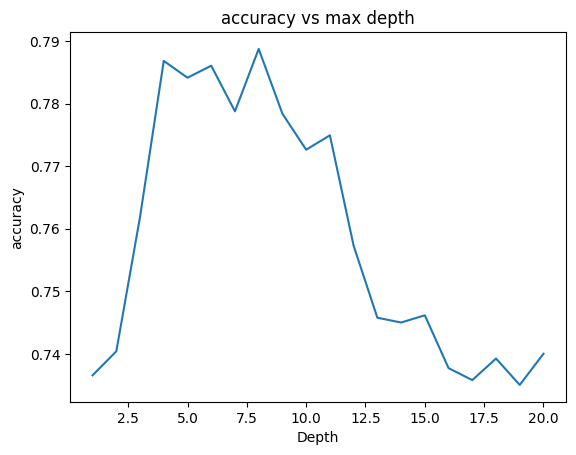

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

acc = []
depth = [i for i in range(1, 21)]

for d in depth:
    model = DecisionTreeClassifier(random_state = 42, max_depth=d)
    model.fit(X_train, y_train)
    prediction = model.predict(X_val)
    correct_pred = (prediction == y_val).sum()
    total_pred = len(y_val)

    acc.append(correct_pred/total_pred)


plt.plot(depth, acc)
plt.xlabel("Depth")
plt.ylabel("accuracy")
plt.title("accuracy vs max depth")
plt.show()



In [46]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42, max_depth=10)
model.fit(X_train, y_train)

prediction = model.predict(X_val)
correct_pred = (prediction == y_val).sum()
total_pred = len(y_val)

acc = (correct_pred/total_pred)
print("Accuracy:", acc)

Accuracy: 0.8013803680981595


In [ ]:
from sklearn.ensemble import RandomForestClassifier



# randomforest with gridsearch

model = RandomForestClassifier(random_state=42)


param_grid = {
  'max_depth': [10, 15, 18],
  'n_estimators': [200, 250, 350, 400],  # Number of trees in the forest
  'criterion': ['gini', 'entropy']
}

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the corresponding accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)



In [47]:
from sklearn.ensemble import GradientBoostingClassifier


model = GradientBoostingClassifier(max_depth=7, random_state=42)
model.fit(X_train, y_train)

print(model.score(X_val, y_val))

importances = model.feature_importances_

feature_names = train_data_df.columns.tolist()

importance_feature_pairs = zip(importances, feature_names)

# Sort the pairs based on importance values in ascending order
sorted_pairs = sorted(importance_feature_pairs)

# Print the sorted feature importances
for importance, feature_name in sorted_pairs:
    print(f"{feature_name}: importance = {importance}")

0.80329754601227
amenities: importance = 0.0013145419009946177
VIP: importance = 0.003151464456733728
Destination: importance = 0.009058803776974088
CryoSleep: importance = 0.02183210421452048
RoomService: importance = 0.03711493504996573
VRDeck: importance = 0.04994138290607109
Age: importance = 0.05297907018324067
Name: importance = 0.05534430512278103
Spa: importance = 0.05905756717375639
HomePlanet: importance = 0.06426624788436287
PassengerId: importance = 0.06722601956090357
ShoppingMall: importance = 0.06754389187993266
FoodCourt: importance = 0.0824339429553688
Cabin: importance = 0.09875152091220521
Transported: importance = 0.32998420202218903


In [48]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

nb_classifier = GaussianNB()
rf_classifier = RandomForestClassifier(n_estimators = 350)
log_reg = LogisticRegression(max_iter=10000)
gradientBoostingClassifier = GradientBoostingClassifier(max_depth=7, random_state=42)

# Initialize Voting Classifier
voting_classifier = VotingClassifier(estimators=[('GradientBoostingClassifier', gradientBoostingClassifier),
 ('Random Forest', rf_classifier), ("Naive Bayes", nb_classifier), ("Log Reg", log_reg)], voting='soft')
voting_classifier.fit(X_train, y_train)
print('The accuracy on the test subset: {:.3f}'.format(voting_classifier.score(X_val, y_val)))

The accuracy on the test subset: 0.812
